In [34]:
import numpy as np

# 線性同餘生成器
def linear_congruential_generator(a=1664525, c=1013904223, m=2**32):
    state = 123456789  # 初始值
    while True:
        state = (a * state + c) % m
        yield state / m

# 初始化 LCG 隨機數生成器
lcg_gen = linear_congruential_generator()

# 生成標準正態近似分佈的數據
def generate_standard_normal_via_clt():
    sum_uniform = sum(next(lcg_gen) for _ in range(12))
    return sum_uniform - 6

# 單變量高斯（正態）分佈生成器
def generate_univariate_gaussian(mean, variance):
    # 生成標準正態分佈的數據
    standard_normal_value = generate_standard_normal_via_clt()
    # 根據給定的均值和變異數進行變換
    gaussian_value = mean + np.sqrt(variance) * standard_normal_value
    return gaussian_value

# 生成指定數量的高斯分佈數據
def generator(N, mu, sigma):
    data = [generate_univariate_gaussian(mu, sigma) for _ in range(N)]
    return np.array(data)  # 回傳 numpy 陣列


def confusion_matrix(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 計算混淆矩陣的各個部分
    TN = np.sum((y_true == 0) & (y_pred == 0))  # True Negative
    FP = np.sum((y_true == 0) & (y_pred == 1))  # False Positive
    FN = np.sum((y_true == 1) & (y_pred == 0))  # False Negative
    TP = np.sum((y_true == 1) & (y_pred == 1))  # True Positive

    # 返回混淆矩陣
    return np.array([[TN, FP], [FN, TP]])

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(theta, X, y):
    predictions = sigmoid(X @ theta)
    return -sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions)) / len(y)

def gradient(theta, X, y):
    predictions = sigmoid(X @ theta)
    return X.T @ (predictions - y) / len(y)

def hessian(theta, X, y):
    predictions = sigmoid(X @ theta)
    D = np.diag((predictions * (1 - predictions)).flatten())
    return X.T @ D @ X / len(y)

def evaluate(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    return cm, sensitivity, specificity


梯度下降法的混淆矩陣:
[[42  8]
 [16 34]]
靈敏度: 0.6800, 特異度: 0.8400

牛頓法的混淆矩陣:
[[40 10]
 [11 39]]
靈敏度: 0.7800, 特異度: 0.8000


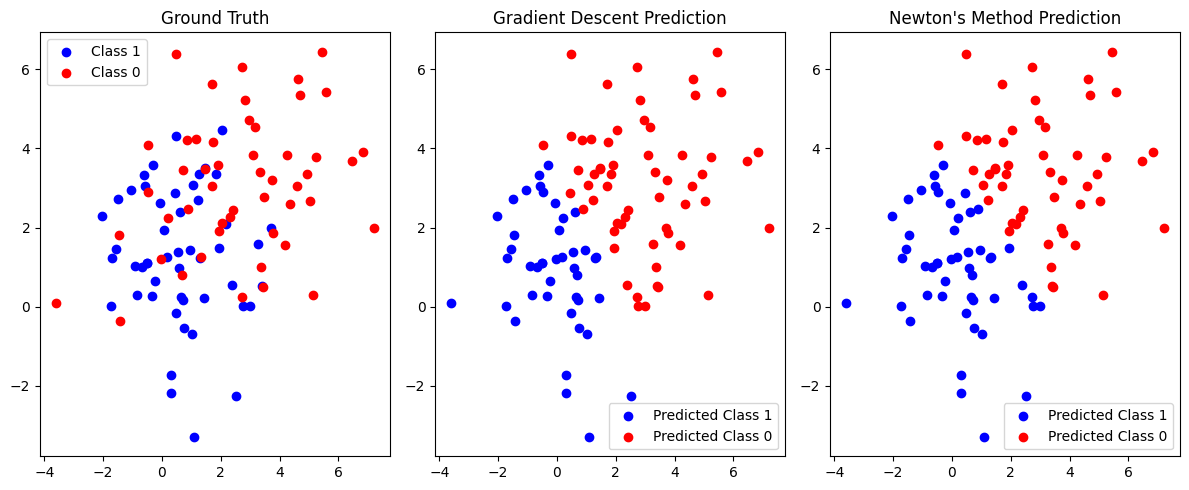

In [35]:
import matplotlib.pyplot as plt

seed = 123456789
n = 50
mx_1, my_1 = 1, 1
mx_2, my_2 = 3, 3
vx_1, vy_1 = 2, 2
vx_2, vy_2 = 4, 4


# 生成 D_1 的數據
X1 = np.column_stack((generator(n, mx_1, vx_1), generator(n, my_1, vy_1)))
y1 = np.ones((n, 1))


# 生成 D_2 的數據
X2 = np.column_stack((generator(n, mx_2, vx_2), generator(n, my_2, vy_2)))
y2 = np.zeros((n, 1))

# 合併資料
X = np.vstack((X1, X2))
y = np.vstack((y1, y2))

# 加入偏置(截距)
X = np.hstack((np.ones((2 * n, 1)), X))

# 初始化參數
theta_gd = np.zeros((X.shape[1], 1))
theta_newton = np.zeros((X.shape[1], 1))

# 最佳化參數：梯度下降法
max_iters = 100
alpha = 0.1
for i in range(max_iters):
    grad = gradient(theta_gd, X, y)
    theta_gd -= alpha * grad

# 最佳化參數：牛頓法
for i in range(max_iters):
    grad = gradient(theta_newton, X, y)
    H = hessian(theta_newton, X, y)

    # 檢查海塞矩陣 H 是否可逆
    try:
        H_inv = np.linalg.inv(H)
        delta_theta = H_inv @ grad
        theta_newton -= delta_theta
    except np.linalg.LinAlgError:
        # 如果 H 不可逆，使用梯度下降更新
        theta_newton -= alpha * grad  # 使用梯度下降法更新


# 預測
predictions_gd = sigmoid(X @ theta_gd) >= 0.5
predictions_newton = sigmoid(X @ theta_newton) >= 0.5

# 計算混淆矩陣、靈敏度和特異度
cm_gd, sensitivity_gd, specificity_gd = evaluate(y, predictions_gd)
cm_newton, sensitivity_newton, specificity_newton = evaluate(y, predictions_newton)

print("梯度下降法的混淆矩陣:")
print(cm_gd)
print(f"靈敏度: {sensitivity_gd:.4f}, 特異度: {specificity_gd:.4f}")

print("\n牛頓法的混淆矩陣:")
print(cm_newton)
print(f"靈敏度: {sensitivity_newton:.4f}, 特異度: {specificity_newton:.4f}")

# 視覺化
plt.figure(figsize=(12, 5))

# Ground Truth
plt.subplot(1, 3, 1)
plt.scatter(X1[:, 0], X1[:, 1], color='blue', label="Class 1")
plt.scatter(X2[:, 0], X2[:, 1], color='red', label="Class 0")
plt.title("Ground Truth")
plt.legend()

# 梯度下降法預測結果
plt.subplot(1, 3, 2)
plt.scatter(X[:, 1][predictions_gd.flatten() == 1], X[:, 2][predictions_gd.flatten() == 1], color='blue', label="Predicted Class 1")
plt.scatter(X[:, 1][predictions_gd.flatten() == 0], X[:, 2][predictions_gd.flatten() == 0], color='red', label="Predicted Class 0")
plt.title("Gradient Descent Prediction")
plt.legend()

# 牛頓法預測結果
plt.subplot(1, 3, 3)
plt.scatter(X[:, 1][predictions_newton.flatten() == 1], X[:, 2][predictions_newton.flatten() == 1], color='blue', label="Predicted Class 1")
plt.scatter(X[:, 1][predictions_newton.flatten() == 0], X[:, 2][predictions_newton.flatten() == 0], color='red', label="Predicted Class 0")
plt.title("Newton's Method Prediction")
plt.legend()

plt.tight_layout()
plt.show()



In [14]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
import numpy as np
import os
from scipy.optimize import linear_sum_assignment

datapath = '/content/gdrive/MyDrive/'

def read_mnist_images(filename):
    with open(filename, 'rb') as f:
        f.read(16)  # skip header
        images = np.fromfile(f, dtype=np.uint8)
        images = images.reshape(-1, 28, 28)  # reshape to (num_images, 28, 28)
    return images

def read_mnist_labels(filename):
    with open(filename, 'rb') as f:
        f.read(8)  # skip header
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

def map_to_2_bins(data_images):
    discrete_train_images = (data_images // 128).astype(int)
    return discrete_train_images


class EMAlgorithm:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.means = 0.3 + 0.6 * np.random.rand(n_clusters, 28 * 28)  # 每個類別的像素成功率(k,28*28)這裡用柏努力
        self.priors = np.ones(n_clusters) / n_clusters  # 每個類別的先驗機率
        self.responsibilities_history = []  # 保存每次計算的責任度

    def e_step(self, X): #計算每一個分類K的責任度 r_k
        #初始化
        responsibilities = np.ones((X.shape[0], self.n_clusters)) / self.n_clusters #代表每一張圖為那個分類的機率
        for k in range(self.n_clusters): #更新 r_k
            log_prob = self.log_multivariate_bernoulli(X, self.means[k]) #P(X|k)
            responsibilities[:, k] = np.exp(np.log(self.priors[k]) + log_prob)
        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities_sum[responsibilities_sum == 0] = 1e-10  # 避免分母為零
        responsibilities /= responsibilities_sum

        # 保存當前責任度
        self.responsibilities_history.append(responsibilities)
        return responsibilities

    def m_step(self, X, responsibilities):
        for k in range(self.n_clusters):
            N_k = responsibilities[:, k].sum()
            if N_k > 0:
                self.means[k] = (responsibilities[:, k] @ X) / (N_k) # p_k new
                self.priors[k] = N_k / X.shape[0] # respond_sum/28*28
            else: 0

    def log_multivariate_bernoulli(self, X, mean):  # To calculate P(X|k), X shape is (60000, 28*28)
        epsilon = 1e-10  # 加入一個很小的數
        # 對 mean 和 1 - mean 中的零進行替換
        mean = np.where(mean == 0, epsilon, mean)
        mean = np.where(mean == 1, 1 - epsilon, mean)

        log_prob = X * np.log(mean) + (1 - X) * np.log(1 - mean)
        return log_prob.sum(axis=1)

    def fit(self, X, max_iters=30, tol=1e-5 ):
        for _ in range(max_iters):

            old_means = self.means.copy()
            responsibilities = self.e_step(X)
            self.m_step(X, responsibilities)
            if np.linalg.norm(self.means - old_means) < tol:
                print("break")
                break

In [32]:
# 讀取數據
train_images = read_mnist_images(os.path.join(datapath, 'train-images.idx3-ubyte__'))
train_labels = read_mnist_labels(os.path.join(datapath, 'train-labels.idx1-ubyte__'))

#二質化
binarized_train_images = map_to_2_bins(train_images)

# 使用 EM 演算法
n_clusters = 10  # 數字類別數
em = EMAlgorithm(n_clusters)
binarized_images_reshaped = binarized_train_images.reshape(-1, 28 * 28)  # 假設已經二值化
em.fit(binarized_images_reshaped)

# 獲取最終均值和先驗機率
final_means = em.means
final_priors = em.priors

# 預測預測群組
predicted_labels = np.argmax(em.responsibilities_history[-1], axis=1)
n_samples = predicted_labels.shape[0]

# Step 1: 計算混淆矩陣
confusion_matrix = np.zeros((n_clusters, n_clusters), dtype=int)
for true_label, pred_label in zip(train_labels, predicted_labels):
    confusion_matrix[true_label, pred_label] += 1

# Step 2: 計算成本矩陣
cost_matrix = n_samples - confusion_matrix

# Step 3: 使用匈牙利算法找出最佳匹配
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Step 4: 進行配對標籤的替換
# 建立一個字典，用於將預測標籤轉換為最佳配對的真實標籤
label_mapping = {pred: true for true, pred in zip(row_ind, col_ind)}

# 將 predicted_labels 替換為最佳配對的標籤
mapped_labels = np.array([label_mapping[pred] for pred in predicted_labels])

# 輸出結果
print("最佳配對的群組與真實標籤映射:", label_mapping)
print("重新標記後的群組標籤:", mapped_labels)

# `true_labels` 是真實標籤，`predicted_labels` 是 EM 演算法的預測結果
true_labels = train_labels  # 真實標籤

# 初始化混淆矩陣
conf_matrix = np.zeros((n_clusters, n_clusters), dtype=int)

# 計算混淆矩陣
for true, pred in zip(true_labels, mapped_labels):
    conf_matrix[true, pred] += 1

# 計算敏感度和特異度
sensitivity = []
specificity = []

for i in range(n_clusters):
    TP = conf_matrix[i, i]  # 真陽性
    FN = conf_matrix[i, :].sum() - TP  # 假陰性
    FP = conf_matrix[:, i].sum() - TP  # 假陽性
    TN = conf_matrix.sum() - (TP + FP + FN)  # 真陰性

    sens = TP / (TP + FN) if TP + FN != 0 else 0
    spec = TN / (TN + FP) if TN + FP != 0 else 0

    sensitivity.append(sens)
    specificity.append(spec)

    print(f'Class {i}:')
    print(f'Confusion Matrix for class {i}:')
    print(f'Predict {i}       Predict not {i}')
    print(f'Is {i}       {TP}              {FN}')
    print(f'Isn\'t {i}    {FP}            {TN}')
    print(f'Sensitivity (Successfully predict number {i}): {sens:.5f}')
    print(f'Specificity (Successfully predict not number {i}): {spec:.5f}')
    print('')

# 平均敏感度和特異度
print(f'Average Sensitivity: {np.mean(sensitivity):.5f}')
print(f'Average Specificity: {np.mean(specificity):.5f}')

# 計算準確率
accuracy = np.trace(conf_matrix) / conf_matrix.sum()  # 對角線元素總和除以所有元素總和
print(f'Accuracy: {accuracy:.5f}')


最佳配對的群組與真實標籤映射: {0: 0, 7: 1, 6: 2, 3: 3, 2: 4, 4: 5, 1: 6, 9: 7, 8: 8, 5: 9}
重新標記後的群組標籤: [8 5 4 ... 8 6 8]
Class 0:
Confusion Matrix for class 0:
Predict 0       Predict not 0
Is 0       2115              3808
Isn't 0    94            53983
Sensitivity (Successfully predict number 0): 0.35708
Specificity (Successfully predict not number 0): 0.99826

Class 1:
Confusion Matrix for class 1:
Predict 1       Predict not 1
Is 1       6098              644
Isn't 1    1095            52163
Sensitivity (Successfully predict number 1): 0.90448
Specificity (Successfully predict not number 1): 0.97944

Class 2:
Confusion Matrix for class 2:
Predict 2       Predict not 2
Is 2       4558              1400
Isn't 2    1952            52090
Sensitivity (Successfully predict number 2): 0.76502
Specificity (Successfully predict not number 2): 0.96388

Class 3:
Confusion Matrix for class 3:
Predict 3       Predict not 3
Is 3       4231              1900
Isn't 3    4417            49452
Sensitivity (Succes